<div style="background-color:#342184; padding:6px; color:#f3f0ff;">

# Try Finesse 3 
    
## Part II: The Fabry-Perot Cavity

</div>

**Goal:** 
Build a model of cavity that has with spherical mirrors, and lock it at an operating point. 
Along the way we'll use actions to determine the properties of the cavity.

**In this notebook** we will cover:
1. Gaussian cavity (introducing `maxtem`, `cav`, and radius of curvature) https://finesse.ifosim.org/docs/latest/examples/cavity_eigenmodes.html
2. Propagate beam and gaussian shape on transmission (propagate_beam(), `ccd`) https://finesse.ifosim.org/docs/latest/examples/cavity_eigenmodes.html
3. Some cavity properties (`cp`)
4. Introduce dofs and a DC readout to produce TF of cavity pole z->readout (`FrequencyResponse`, second notebook for `fsig`)
5. Turn on modulation and add RF readout (plot PDH signal) https://finesse.ifosim.org/docs/latest/examples/2_pdh_lock.html
6. Optimize demodulation, by hand and then automatically with action https://finesse.ifosim.org/docs/latest/examples/2_pdh_lock.html
7. Add lock and show that moving the input mirror causes the end mirror to follow

In [2]:
# import the finesse package and actions
import finesse
import finesse.analysis.actions as fa

import numpy as np
import matplotlib.pyplot as plt

# initialize standard plot settings and style
finesse.init_plotting()

## Modeling a cavity with Gaussian beams

We'll start with a plane-waves cavity, as seen in notebook 1. The Finesse 3 katscript for the cavity is provided below. We'll go ahead and add an electro-optic modulator (`eom`) just after the laser, since we'll be needing that later. Notice the `link` command can be used to connect multiple components together when we aren't interested in keeping track of individual spaces.

In [3]:
model = finesse.Model()
model.parse("""
l l1
mod eom f=15M midx=0.7 order=0

bs bs1
m m1 R=0.9 T=0.1
s scav m1.p2 m2.p1 L=1
m m2 R=0.9 T=0.1

link(l1, 0.1, eom, 0.1, bs1.p1, bs1.p3, 0.1, m1)

# detectors
pd refl bs1.p4.o
pd circ m2.p1.o
pd trans m2.p2.o
""")

Upgrading a model from plane-waves to using Gaussian beams requires 3 main elements:
1. curved optics
2. a defined beam parameter to propagate through the optical system
3. a maximum order of Hermite-Gaussian modes to include in the calculation

Typically (1) is achieved either by including lenses or spherically curved mirrors. We can do the latter very compactly by just including the curvature as a parameter when we define a mirror (e.g. `m m1 R=0.9 T=0.1 Rc=-0.7`). In our case, since `m1` is already in our model we can instead add this parameter directly using  python commands. 

(2) requires careful attention: the choice of beam parameter can affect how efficiently the beam shape is described, i.e. how many modes you need to consider in (3).  The usual method is to define the optical cavity(s) in the system, using the `cav` command. This will calculate the eigenmode of the cavity, using the shortest circular path back to the provided node, and use it as the basis when propagating the beam (assuming it is stable). 

Note: Curvatures in Finesse:
Curvatures are defined *as seen by the first port of an optic*. Therefore to make  e.g. a confocal cavity, the input mirror will have *negative* curvature, while the end mirror has positive curvature. 

### TASK 1: making the model Gaussian

For our model we will assume the beam is a perfect fundamental Gaussian mode, defined by our cavity. 

Parse the Finesse commands for the following:
 - add appropriate curvatures to mirrors m1 and m2 (`model.[opticname].Rc=0.7`)
 - include the fundamental HG00 mode (`model.modes(maxtem=0)`)
 - define the cavity formed by m1 and m2 (`model.parse("cav cav1 m1.p2.o")`)

### TASK 2: looking at the beam shape

To get a visual sense of the `model` you  just parsed code into, you can next use the `propagate_beam` function [[details]](https://finesse.ifosim.org/docs/develop/api/model/generated/finesse.model.Model.propagate_beam.html#finesse.model.Model.propagate_beam) to propagate the beam profile of our Gaussian cavity from node `model.m2.p1.o` back to node `model.l1.p1.i` in the "x" direction. Use the syntax:
`prop = finesse.tracing.tools.propagate_beam(...)`

Plot this output using `prop.plot()` to show the cavity eigenmode and accumulated Gouy phase as the beam is traced between the two nodes, and print the results using `print(prop)`to see a detailed view of the beam parameters at each node along the path.

Finally, make a `deepcopy` of the model (`model2=model.deepcopy()`), parse the code for a `ccd` detector [[syntax]](https://finesse.ifosim.org/docs/develop/usage/elements/detectors.html#kat-element-ccd) that will sense the field transmitted from the cavity, and plot the resulting transverse image of the beam using `out.plot()`. 

_`deepcopy` can be used to make an editable copy of a model, while preserving the original model for later use._

### TASK 3: Cavity properties

The properties of the cavity can be accessed from the model after you run the simulation. Examples include ([see the documentation](https://finesse.ifosim.org/docs/latest/api/components/cavity/finesse.components.cavity.Cavity.html#finesse.components.cavity.Cavity) for more details):

- `loss`: round-trip loss as a fraction of the incoming power
- `finesse`: the cavity finesse
- `FSR`: free spectral range [Hz]
- `FWHM`: full-width at half-maximum (i.e. linewidth) [Hz]
- `pole`: cavity pole frequency [Hz]
- `g`: stability as g-factor
- `gouy`: accumulated round-trip Gouy phase [deg]
- `q`: eigenmode

Additionally, a cavity property can be combined with an axis sweep and plotted using a `cavity_property` detector (or `cp`) with the syntax `cp name cavity prop`. To see the full list of options here, [see the documentation](https://finesse.ifosim.org/docs/latest/api/detectors/cavity_detector/finesse.detectors.cavity_detector.CavityPropertyDetector.html).

1. Run the model (`model.run()`), then output the pole frequency of the cavity in Hz using `model.cav1.pole`.
2. Make a `deepcopy` of the model, parse a `cp` detector, and plot the waist size as a function of `m1.Rcx`.

_the radius of curvature of optics in the model is stored as values `Rcx` and `Rcy`, rather than a common value of `Rc`._

## Degrees of Freedom, Readout, and Actions

Finesse's main use case is for understanding the frequency-dependent behaviour of interferometers through calculating transfer functions. In Finesse 3 there are now several ways of achieving this. Notebook 02b shows an example of a method that will be more familiar to Finesse 2 users, using `xaxis` commands combined with introducing signal modulations via `sgen` commands. In this notebook, we'll instead demonstrate an expandable method based on a few new Finesse 3 concepts: degrees of freedom, readouts, and the `FrequencyResponse` action.

#### Degrees of freedom

Degrees of freedom, or DOFs, allow us to drive multiple nodes with the same signal at different amplitudes. For example, we can define a DOF which moves the two end mirrors of our cavity in opposite directions but identical amplitudes with:

`dof wiggle m1.dofs.z +1 m2.dofs.z -1`

We can then use `wiggle.DC` to manipulate this DOF.

#### Readouts

In essence readouts represent a photodetector or some other measurement device that produces an electronic signal in response to the optical field. Therefore readout components will always have one or more optical ports that generate an electrical signal which is then output at one or more electronic ports. These components are typically used for computing transfer functions or AC models of closed loop systems, where the electrical output can be filtered and then fed back into another component.

For now, we'll use a DC readout (`readout_dc`) to measure the power transmitting through the cavity.

#### Actions

Actions are used to run analysis tasks. They pre-define all tasks before they are run, which allows them to optimize
the model by ignoring parameters which are not required to perform the action. Actions can do either a single simple task or execute a complex set of tasks. Although most users will just use existing actions, they are designed to be easy to write/expand with a bit of Python knowledge.

We've already seen the most common action `Xaxis` which simply steps a parameter along a sequence of values and stores the output of the detectors, then returns the parameter to its original value at the end of the analysis.

We can produce the transfer function from an input to an output by using the `FrequencyResponse` action. This runs a signal simulation which injects a signal into the input node and demodulates the signal at the output node, returning the ratio. `FrequencyResponse` only accepts `SignalNode`s, which are either mechanical (e.g., `mirror.mech.z`) or electrical (e.g., `readout.DC`).

More information on actions, analyses, and solutions are available [in the documentation](https://finesse.ifosim.org/docs/latest/usage/analyses/index.html).


#### Example
Here, we plot the frequency response of the cavity by applying motion to the end mirror. You can compare this to the pole frequency calculated above.

_Note: in this case, since we are just moving the end mirror, we could also directly output the transfer function for the mechanical degree of freedom of the mirror `m2.mech.z` to `out_dc`, rather than using a dof command. We've chosen to show `dof` here as simple example of this more scalable method._

[-28811.63247783+2.29461268e-02j -28811.63247783+2.31319964e-02j
 -28811.63247783+2.33192146e-02j ...   1576.940537  +8.47056842e+02j
   1556.84841147+8.28432169e+02j   1536.94356203+8.10193004e+02j]


<Figure size 576x355.968 with 0 Axes>

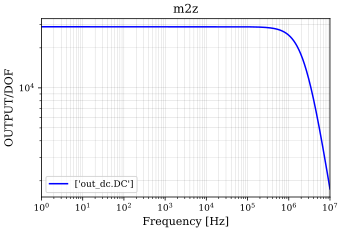

In [9]:
model3 = model.deepcopy()

model3.parse("""
dof m2z m2.dofs.z +1
readout_dc out_dc m2.p2.o output_detectors=true
fsig(1)
""")


with model3.temporary_parameters():
    # detune to break symmetry
    model3.m2.phi = 0.001

    tf = model3.run(fa.FrequencyResponse(
        np.geomspace(1e0, 1e7, 2000),
        ["m2z"],
        ["out_dc.DC"],
    ))

    tf.plot()
    print(tf["m2z", "out_dc.DC"])

## Locking the cavity
### TASK 4: The error signal

We will emulate the Pound-Drever-Hall method to lock our cavity. To generate an error signal, we first need to turn on modulation and add RF readout.

Above, the modulator component `eom` was included in the model, but with `order=0` such that no modulations were produced. (Tip: you can use this method to speed up more complex simulations, if your current analysis does not depend on the RF sideband fields)

Now, make a deepcopy of `model3`, and set the modulation order to 1 (`model.eom.order = 1`) to include the first order of phase modulated sidebands in the simulation. 

Next, parse a `readout_rf` component [[syntax](https://finesse.ifosim.org/docs/latest/usage/elements/readouts.html#kat-element-readout-rf)] named `pdh`, which measures the field reflected from the cavity at node `m1.p1.o`, and demodulates at the frequency of the modulator `eom.f`. 

Finally, plot the error signal in I and Q (`out.plot("pdh_I", "pdh_Q")`) while using an `xaxis` action to scan `m2z.DC` over a range of -100 to +100 degrees.

### Optimizing the demodulation phase

The error signal can be optimized by tuning the demodulation phase so the optical response is maximized on either I or Q.

#### Example: optimizing by-hand
Here, we optimize the demodulation phase manually to illustrate the process before providing an action which optimizes the phase for us.

We start by parsing in several detectors with different demodulation phases. We can see from the plots that the optimium is somewhere between 0 and 18 degrees.


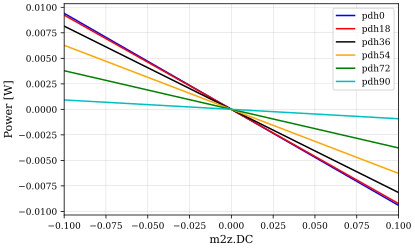

In [11]:
model6 = model5.deepcopy()
phases = []
for phase in np.linspace(0, 90, endpoint=True, num=6):
    phases.append(f"pdh{phase:.0f}")
    model6.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=eom.f phase={phase:.0f}")

model6.parse("xaxis(m2z.DC, lin, -0.1, 0.1, 400)")
model6.run().plot(*phases);

Next we repeat the process above, but add more detectors and plot the gradients. We can see the maximum occurs at 6 degrees (+/- 180 deg).

Maximum error signal gradient occurs at 6.0 degrees


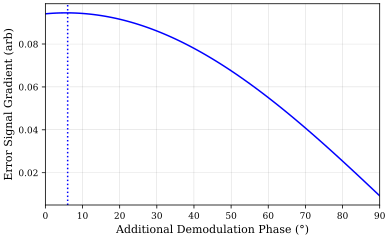

In [12]:
model = model5.deepcopy()
# Do a 2D set of steps, move the m2z.DC by some small steps for an array of PDH demodulation phases
out = model.run("x2axis(m2z.DC, lin, -0.1, 0.1, 1, pdh.phase, lin, 0, 90, 90)")
dStep = 0.2
grad = abs(out['pdh_I'][1, :] - out['pdh_I'][0, :])/dStep

idxmax = np.argmax(np.abs(grad))
print(f'Maximum error signal gradient occurs at {out.x2[idxmax]} degrees')

# Plot.
plt.plot(out.x2, grad)
plt.axvline(out.x2[idxmax], linestyle=":")
plt.xlabel('Additional Demodulation Phase (°)')
plt.ylabel('Error Signal Gradient (arb)');

### Using actions for optimisation

Many of the tasks we want to perform with simulations is finding some optimal state, be it maximum power, or optimal demodulation phase. In Python we typically use Scipy optimisation routines to minimize or maximize some cost function.

The scipy optimisers are wrapped up in the `maximize` and `minimize` actions, so you can optimise some detector output as a function of a model parameters.

In [13]:
model6c = model5.deepcopy()
model6c.m2z.DC = 2
# Maximize the circulating power with respect to the cavity length
opt = model6c.run("maximize(circ, m2z.DC)")
print(opt.x) # print the optimised output, this should be nerly "zero"

[-1.77635684e-15]


In [14]:
# we can get help about the solution returned using the ? operator in the notebook
opt?

Type:        OptimizeSolution
String form:
- Solution Tree
○ maximize - OptimizeSolution
File:        ~/git/finesse3/src/finesse/analysis/actions/optimisation.py
Docstring:  
Solution for an optimization action.

Attributes
----------
result : scipy.optimize.optimize.OptimizeResult
    Result from the scipy optimization method that contains the results and some
    extra data about the process and any errors that might happen.

parameters : [Parameter | tuple]
    Name or names of parameters that were optimized over

x : [numeric | ndarray]
    The final minimized values for the parameters requested.


We want to optimise the amount of cavity length signal that appears in the in-phase PDH readout.

For this we have to add a signal generator `sgen` (which injects a signal into the cavity length) and an amplitude detector `ad` which measures the electrical signal at the PDH inphase output (which is the signal node `pdh.I.o`). Once we do that we can use the maximise this signal with respect to the PDH demoduation phase, using the `maximize` action.

In [15]:
model6d = model5.deepcopy()

# Drive a signal into the degree of freedom of interest 
model6d.parse("""
sgen sig m2z.AC 
# Make a detector to look at the signal generated at the
# output of the inphase PDH readout
ad I_signal pdh.I.o f=fsig 
""")

# Now we can maximise 
opt = model6d.run("""
maximize(I_signal, pdh.phase)
""")

# to see the optimial demodulation phase
print(opt.x)

[5.591875]


### TASK 5: Optimizing with an Action

We can also use the action `OptimiseRFReadoutPhaseDC` to optimize the phase for us by providing pairs of DOFs and RF readouts (e.g., `OptimizeRFReadoutPhaseDC(dof1, readout1, dof2, readout2)`). Keep in mind `OptimiseRFReadoutPhaseDC` will modify the model directly.

Deepcopy your model from task 4 and use `OptimiseRFReadoutPhaseDC` to optimize the demodulation phase. Look this action up in the FINESSE 3 manual. Print the value before and after optimization to show it has been maximized.

### TASK 6: Lock it!

A `lock` [[syntax](https://finesse.ifosim.org/docs/latest/usage/elements/control_and_filtering.html#kat-element-lock)] can be used to compute and apply feedback to a given parameter using an error signal. The value fed back into the parameter will be the value of the error signal multiplied by the *gain*. Once defined, the locks can be run using the action `RunLocks` which will attempt to iteratively bring the error signal to zero, within the provided *accuracy*.

1) Deepcopy and add a lock which feeds the in-phase PDH error signal `pdh_I` back into the motion of the mirror (`m2z.DC`). Use a gain of 10 and accuracy of 1e-8.

2) Look up the `RunLocks` command in the manual and run the action. This should reduce the error signal to "zero", or within the accuracy.

3) Look up the `RunLocksSolution` and plot how the error signals are getting changed

4) Try plotting the error signal before and after running the locks and see how it has changed. Does the cavity circulating power get maximised?